# Early Fusion: Model Interpretation

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/'
output_path = '../out/'
# Global configuration path
glob_conf_path = '../../../config/'

### Load global variables

In [3]:
exec(open(os.path.join(glob_conf_path, 'global_config_paper.py')).read())
exec(open(os.path.join(glob_conf_path, 'config_feature_contributions.py')).read())

### Load, prepare, and fuse data

#### Load

In [4]:
train_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_train.csv'))
train_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_train.csv'))

#### Fuse data

In [5]:
# Fuse training data (audio + video)
train_audio_id_df_tmp = train_audio_df.drop(columns=['target','actor_id','group'])              # Drop target, actor_id, and group from the audio dataframe, since they are already in the video dataframe
train_df = train_audio_id_df_tmp.merge(train_video_df, how='left', on='file_id')                # Merge on file_id
train_df = train_df[[c for c in train_df if c not in ['file_id', 'actor_id', 'group','target']]
                    + ['file_id', 'actor_id', 'group','target']]                                # Reorder columns so file_id, actor_id, and target are at the end of the dataframe
train_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,file_id,actor_id,group,target
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.363398,0.0,0.007299,0.092857,0.092857,0.258065,0,1,4,1
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.584047,0.0,0.007299,0.057143,0.057143,0.161290,1,1,4,1
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.380347,0.0,0.029197,0.039286,0.039286,0.096774,2,1,4,1
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.303059,0.0,0.014599,0.035714,0.035714,0.129032,3,1,4,1
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.255539,0.0,0.058394,0.064286,0.064286,0.225806,4,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.455030,0.051548,0.459465,0.432665,0.428898,0.042556,0.136981,0.009610,0.209519,0.008897,...,0.358930,0.0,0.000000,0.569286,0.569286,0.161290,1255,10,5,17
1255,0.220083,0.513768,0.031770,0.317742,0.347561,0.422764,0.358086,0.306875,0.228330,0.014988,...,0.507585,0.0,0.021898,0.107143,0.107143,0.258065,1256,10,5,17
1256,0.270762,0.520014,0.024084,0.363869,0.372689,0.462329,0.259245,0.118235,0.245574,0.060586,...,0.551471,0.0,0.007299,0.078571,0.078571,0.322581,1257,10,5,17
1257,0.450948,0.089263,0.419079,0.440764,0.442042,0.104093,0.162826,0.065396,0.205408,0.005887,...,0.358960,0.0,0.000000,0.328571,0.328571,0.225806,1258,10,5,17


## Model interpretation

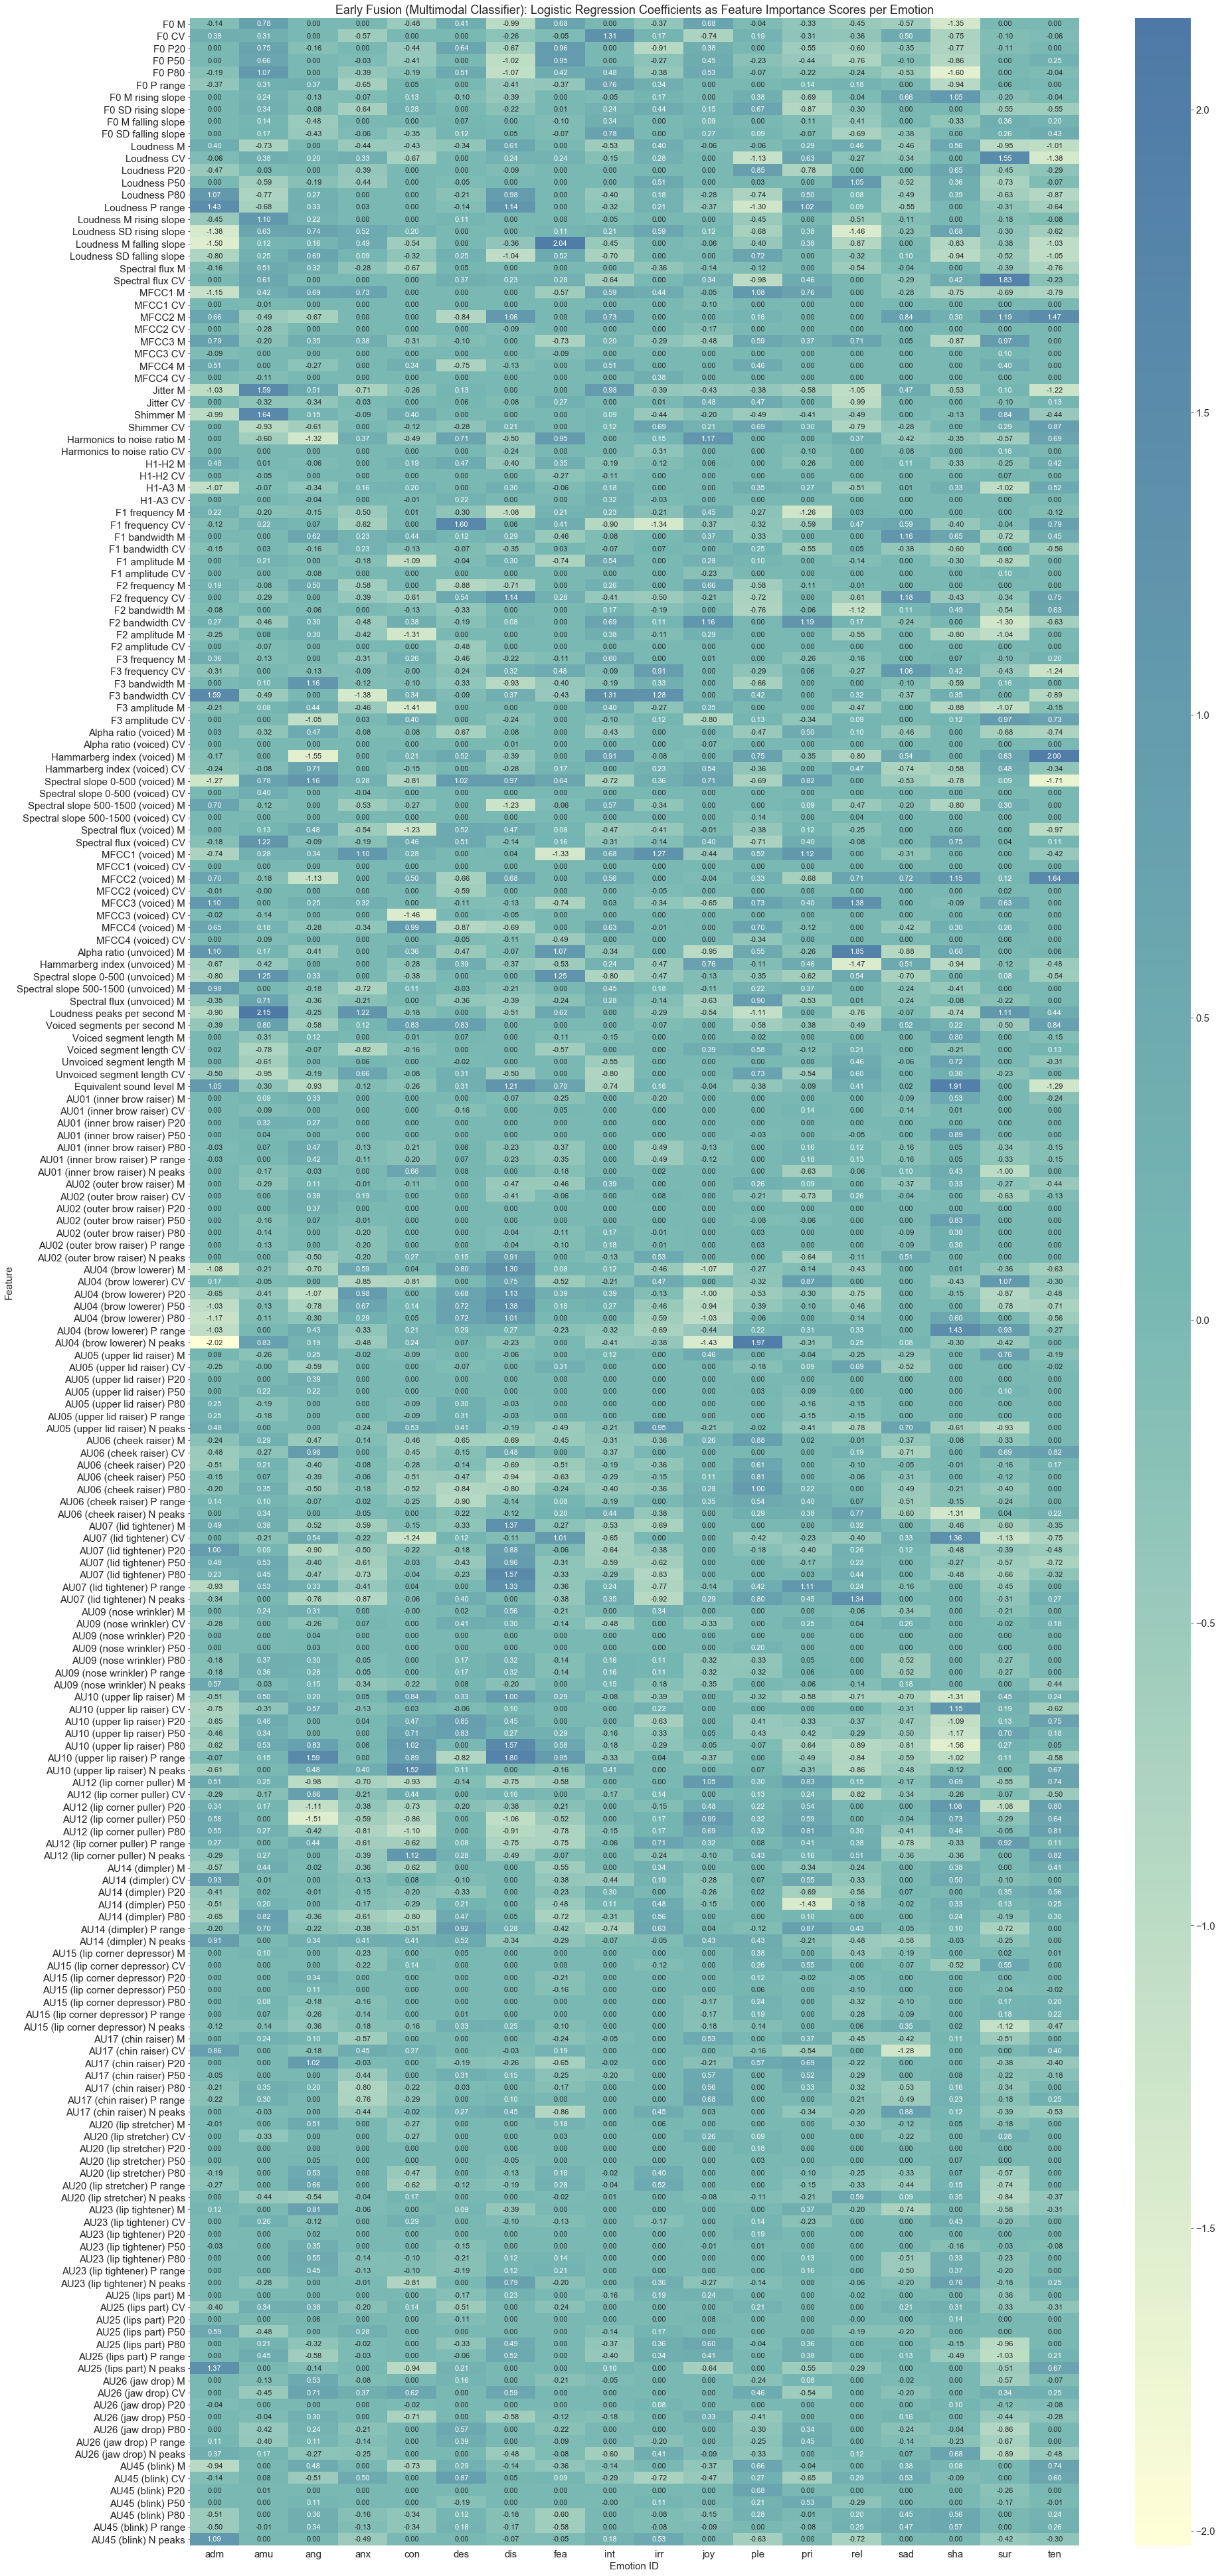

In [6]:
# Get features
feat = list(train_df.drop(columns=['file_id', 'actor_id', 'group','target']))


# Load the model from disk
file_path = os.path.join(output_path,'aus_egemaps','models','pipeline_early_fusion_clf_elastic_net.sav')
clf = pickle.load(open(file_path, 'rb'))
coef_df = pd.DataFrame(clf.coef_, index=list(emotion_eng_id_to_emotion_num.keys()), columns=feat).T
coef_df = coef_df.reindex(sorted(coef_df.columns), axis=1)
coef_df = coef_df.rename(var_name_to_feat, axis=0)
coef_df = coef_df.reindex(list(var_name_to_feat.values())).dropna()
coef_df.to_csv(os.path.join(output_path,'aus_egemaps','others','tmp','early_fusion_multimodal_classifier_feature_contributions.csv'), index=True, header=True)

# Plot results
sns.set_style({'ytick.left': True})
plt.figure(figsize=(30,70))
sns.heatmap(coef_df, annot=True, annot_kws={"size": 11}, fmt='.2f', cmap=conf_cmap, cbar_kws={"aspect": 45})
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
plt.savefig(os.path.join(output_path,'aus_egemaps','others','report_early_fusion_multimodal_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.title('Early Fusion (Multimodal Classifier): Logistic Regression Coefficients as Feature Importance Scores per Emotion')
plt.savefig(os.path.join(output_path,'aus_egemaps','others','early_fusion_multimodal_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.show()

sns.set_style({'ytick.left': False})

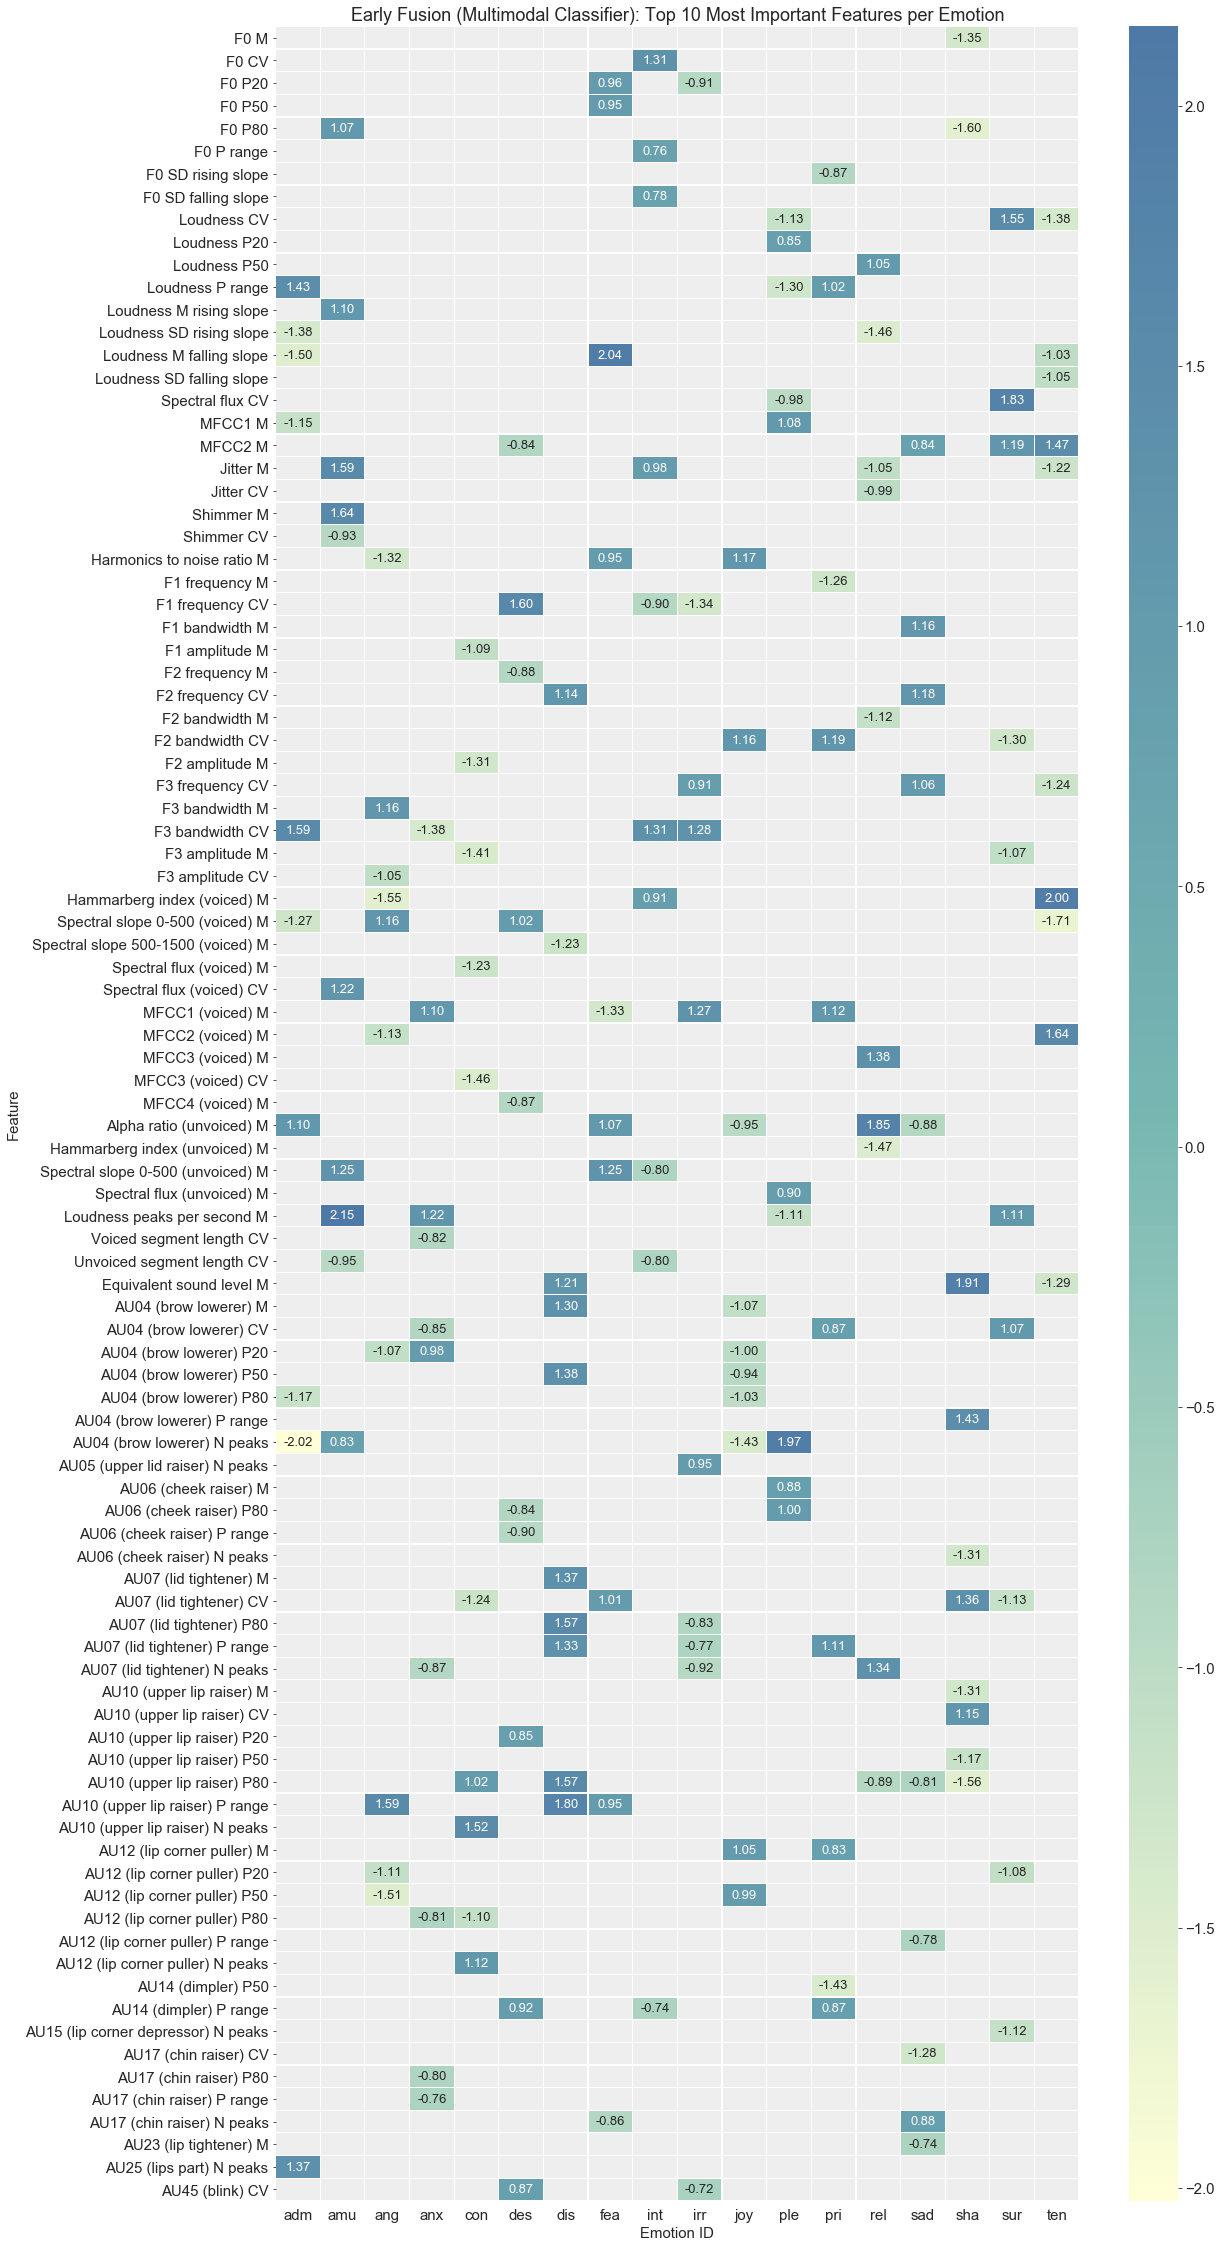

In [7]:
data = coef_df.copy()
data_abs = data.abs()
top_features_per_emotion = {}
n = 10
for c in data.columns:
    top_features_per_emotion[c] = data_abs.nlargest(n, columns=c).index.tolist()

#all_features = set(data.index.tolist())
features_to_keep = set([item for sublist in top_features_per_emotion.values() for item in sublist])
#features_to_drop = all_features - features_to_keep

data_reduced = data.loc[features_to_keep].reindex(data.index).dropna()
data_reduced = data_reduced.reindex(feat_order_summary_multi)
mask = np.array([[feat not in top_features_per_emotion[c] for feat in data_reduced.index] for c in data_reduced.columns]).T
data_reduced.mask(mask).to_csv(os.path.join(output_path,'aus_egemaps','others','tmp','early_fusion_multimodal_classifier_feature_contributions_top_'+str(n)+'.csv'), index=True, header=True)


# Plot results
sns.set_style({'ytick.left': True})
plt.figure(figsize=(18,40))
hm = sns.heatmap(data_reduced, annot=True, annot_kws={"size": 13}, fmt='.2f', cmap=conf_cmap, cbar_kws={"aspect": 45}, linewidth=0.25, mask=mask)
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
ax = hm.axes
ax.set_facecolor((238/255, 238/255, 238/255))
plt.savefig(os.path.join(output_path,'aus_egemaps','others','report_early_fusion_multimodal_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.title('Early Fusion (Multimodal Classifier): Top ' + str(n) + ' Most Important Features per Emotion')
plt.savefig(os.path.join(output_path,'aus_egemaps','others','early_fusion_multimodal_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.show()

sns.set_style({'ytick.left': False})

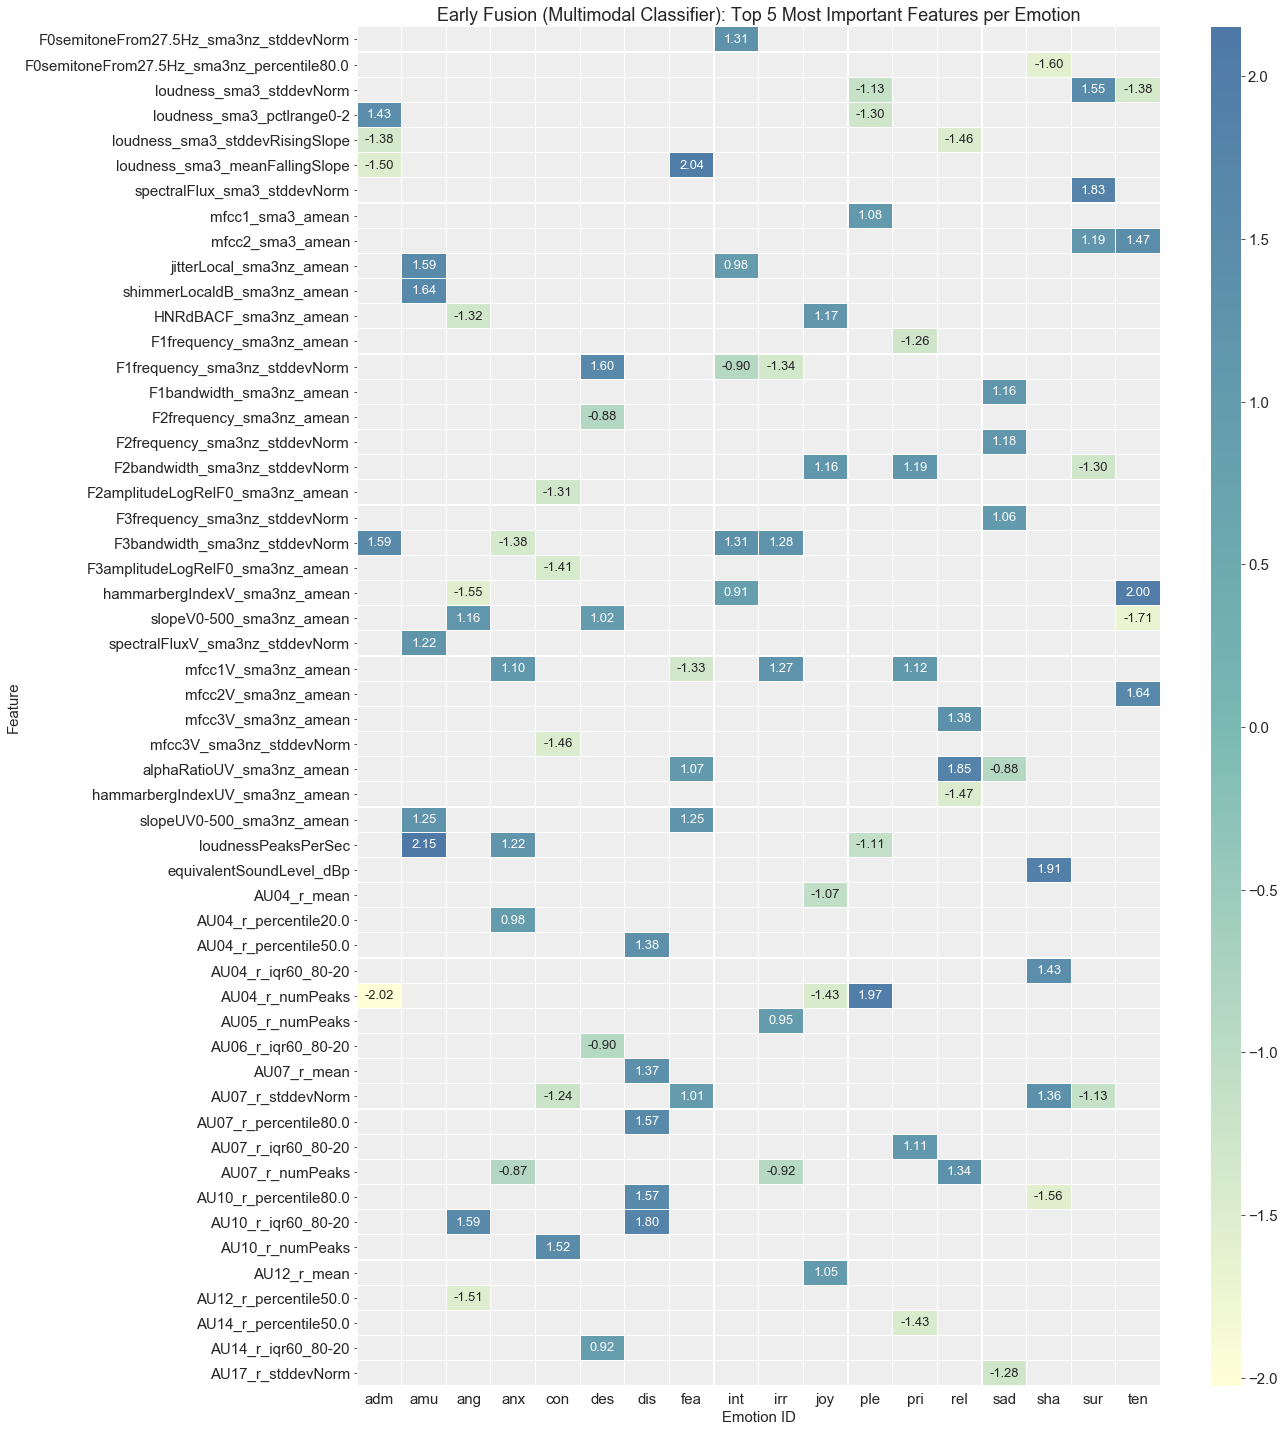

In [20]:
data = coef_df.copy()
data_abs = data.abs()
top_features_per_emotion = {}
n = 5
for c in data.columns:
    top_features_per_emotion[c] = data_abs.nlargest(n, columns=c).index.tolist()

#all_features = set(data.index.tolist())
features_to_keep = set([item for sublist in top_features_per_emotion.values() for item in sublist])
#features_to_drop = all_features - features_to_keep

data_reduced = data.loc[features_to_keep].reindex(data.index).dropna()
mask = np.array([[feat not in top_features_per_emotion[c] for feat in data_reduced.index] for c in data_reduced.columns]).T
data_reduced.mask(mask).to_csv(os.path.join(output_path,'aus_egemaps','others','tmp','early_fusion_multimodal_classifier_feature_contributions_top_'+str(n)+'.csv'), index=True, header=True)

# Plot results
sns.set_style({'ytick.left': True})
plt.figure(figsize=(18,25))
hm = sns.heatmap(data_reduced, annot=True, annot_kws={"size": 13}, fmt='.2f', cmap=conf_cmap, cbar_kws={"aspect": 45}, linewidth=0.25, mask=mask)
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
ax = hm.axes
ax.set_facecolor((238/255, 238/255, 238/255))
plt.savefig(os.path.join(output_path,'aus_egemaps','others','report_early_fusion_multimodal_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.title('Early Fusion (Multimodal Classifier): Top ' + str(n) + ' Most Important Features per Emotion')
plt.savefig(os.path.join(output_path,'aus_egemaps','others','early_fusion_multimodal_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.show()

sns.set_style({'ytick.left': False})